## 필요한 Library 가져오기

In [1]:
# pip install xlrd
# pip install tensorflow
# pip install pandas
# pip install seaborn
# pip install scikit-learn

import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns

## dataset 가져오기

In [2]:
dataset = pd.read_excel("ISEARdata.xls")

In [3]:
dataset.head()

,emotion,sentence
0,joy,[ On days when I feel close to my partner and ...
1,fear,Every time I imagine that someone I love or I ...
2,anger,When I had been obviously unjustly treated and...
3,sadness,When I think about the short time that we live...
4,disgust,At a gathering I found myself involuntarily si...


In [4]:
dataset['emotion'].value_counts()

anger      1094
sadness    1094
disgust    1094
shame      1094
fear       1093
joy        1092
guilt      1091
Name: emotion, dtype: int64

In [5]:
label_dict = {"anger" : 0, "sadness" : 1, "disgust" : 2,"shame" : 3, "fear" : 4, "joy" : 5,"guilt" : 6 }
labels = list(label_dict.keys())
dataset["label"] = dataset["emotion"].replace(labels, list(range(len(labels))))

In [6]:
dataset.head()

,emotion,sentence,label
0,joy,[ On days when I feel close to my partner and ...,5
1,fear,Every time I imagine that someone I love or I ...,4
2,anger,When I had been obviously unjustly treated and...,0
3,sadness,When I think about the short time that we live...,1
4,disgust,At a gathering I found myself involuntarily si...,2


## 전처리

In [7]:
print(len(dataset))

7652


In [8]:
print(dataset.isnull().sum())

emotion     0
sentence    0
label       0
dtype: int64


In [9]:
dataset['sentence'].nunique()

7489

In [10]:
# 중복 제거
print("중복 제거 전 데이터 갯수 : ",len(dataset))
dataset.drop_duplicates(subset=['sentence'], inplace=True)
print("중복 제거 후 데이터 갯수 : ",len(dataset))

중복 제거 전 데이터 갯수 :  7652
중복 제거 후 데이터 갯수 :  7489


<AxesSubplot:>

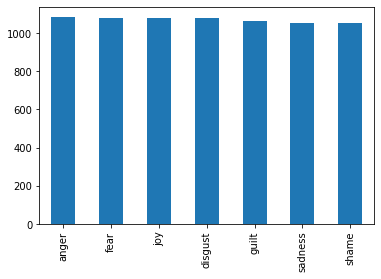

In [11]:
dataset['emotion'].value_counts().plot(kind = 'bar')

### 학습 데이터와 테스트 데이터 분리

In [12]:
from sklearn.model_selection import train_test_split

X_data = dataset["sentence"]
Y_data = dataset["label"]

x_tr, x_te, y_tr, y_te = train_test_split(X_data, Y_data, test_size = 0.3, random_state = 42, stratify = Y_data)


## 토큰화

In [13]:
vocab_size = 2000
max_length = 50

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(x_tr)

x_tr_tokenized = tokenizer.texts_to_sequences(x_tr)
x_tr_padded = pad_sequences(x_tr_tokenized, maxlen = max_length)

x_te_tokenized = tokenizer.texts_to_sequences(x_te)
x_te_padded = pad_sequences(x_te_tokenized, maxlen = max_length)

In [15]:
from tensorflow.keras.utils import to_categorical

y_tr = to_categorical(y_tr)
y_te = to_categorical(y_te)

## 모델 생성

In [16]:
embedding_dim = 256
batch_size = 32
learning_rate = 0.0002

In [17]:
from tensorflow.keras.layers import LSTM, Embedding, Dense, Bidirectional, Dropout
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(50)))
model.add(Dense(7, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 256)         512000    
                                                                 
 dropout (Dropout)           (None, None, 256)         0         
                                                                 
 bidirectional (Bidirectiona  (None, 100)              122800    
 l)                                                              
                                                                 
 dense (Dense)               (None, 7)                 707       
                                                                 
Total params: 635,507
Trainable params: 635,507
Non-trainable params: 0
_________________________________________________________________


In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc'])
history = model.fit(x_tr_padded, y_tr, batch_size=batch_size, epochs=20, validation_data=(x_te_padded, y_te))

Epoch 1/20
164/164 [==============================] - 9s 38ms/step - loss: 1.9398 - acc: 0.1873 - val_loss: 1.9292 - val_acc: 0.2359
Epoch 2/20
164/164 [==============================] - 5s 32ms/step - loss: 1.8847 - acc: 0.2896 - val_loss: 1.8308 - val_acc: 0.3111
Epoch 3/20
164/164 [==============================] - 5s 32ms/step - loss: 1.6577 - acc: 0.4203 - val_loss: 1.5744 - val_acc: 0.4299
Epoch 4/20
164/164 [==============================] - 5s 32ms/step - loss: 1.3842 - acc: 0.5183 - val_loss: 1.4609 - val_acc: 0.4668
Epoch 5/20
164/164 [==============================] - 5s 32ms/step - loss: 1.1901 - acc: 0.5929 - val_loss: 1.3878 - val_acc: 0.4918
Epoch 6/20
164/164 [==============================] - 5s 32ms/step - loss: 1.0554 - acc: 0.6442 - val_loss: 1.3554 - val_acc: 0.5029
Epoch 7/20
164/164 [==============================] - 6s 35ms/step - loss: 0.9662 - acc: 0.6787 - val_loss: 1.3592 - val_acc: 0.5251
Epoch 8/20
164/164 [==============================] - 5s 33ms/step - 

## 결과 확인

In [ ]:
from sklearn.metrics import f1_score,classification_report
from sklearn.metrics import confusion_matrix,plot_confusion_matrix

pred = model.predict(x_te_padded)

y_test = np.argmax(y_te,axis=1)
y_pred = np.argmax(pred,axis=1)

print(classification_report(y_test,y_pred))

In [ ]:
cfm = confusion_matrix(y_test,y_pred)
df = pd.DataFrame(cfm)
sns.heatmap(df,cmap="Blues",annot=True, fmt="d")